In [126]:
# --- MACHINE LEARNING SOLUTION ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, roc_auc_score, confusion_matrix,
                            precision_recall_curve, make_scorer)
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.compose import ColumnTransformer
import joblib
import warnings
warnings.filterwarnings('ignore')

In [127]:
# ======================
#  DATA LOADING & PREPROCESSING
# ======================
print("Loading data...")
data = pd.read_csv('data.csv')

# Convert target variable
data['OBJ'] = data['OBJ'].map({'NO': 0, 'SI': 1})

# Handle missing values
print("\nHandling missing values...")
data.fillna(data.median(numeric_only=True), inplace=True)

Loading data...

Handling missing values...



=== DATA QUALITY ANALYSIS ===
Class Distribution:
OBJ
0    0.7381
1    0.2619
Name: proportion, dtype: float64


<Figure size 1500x1000 with 0 Axes>

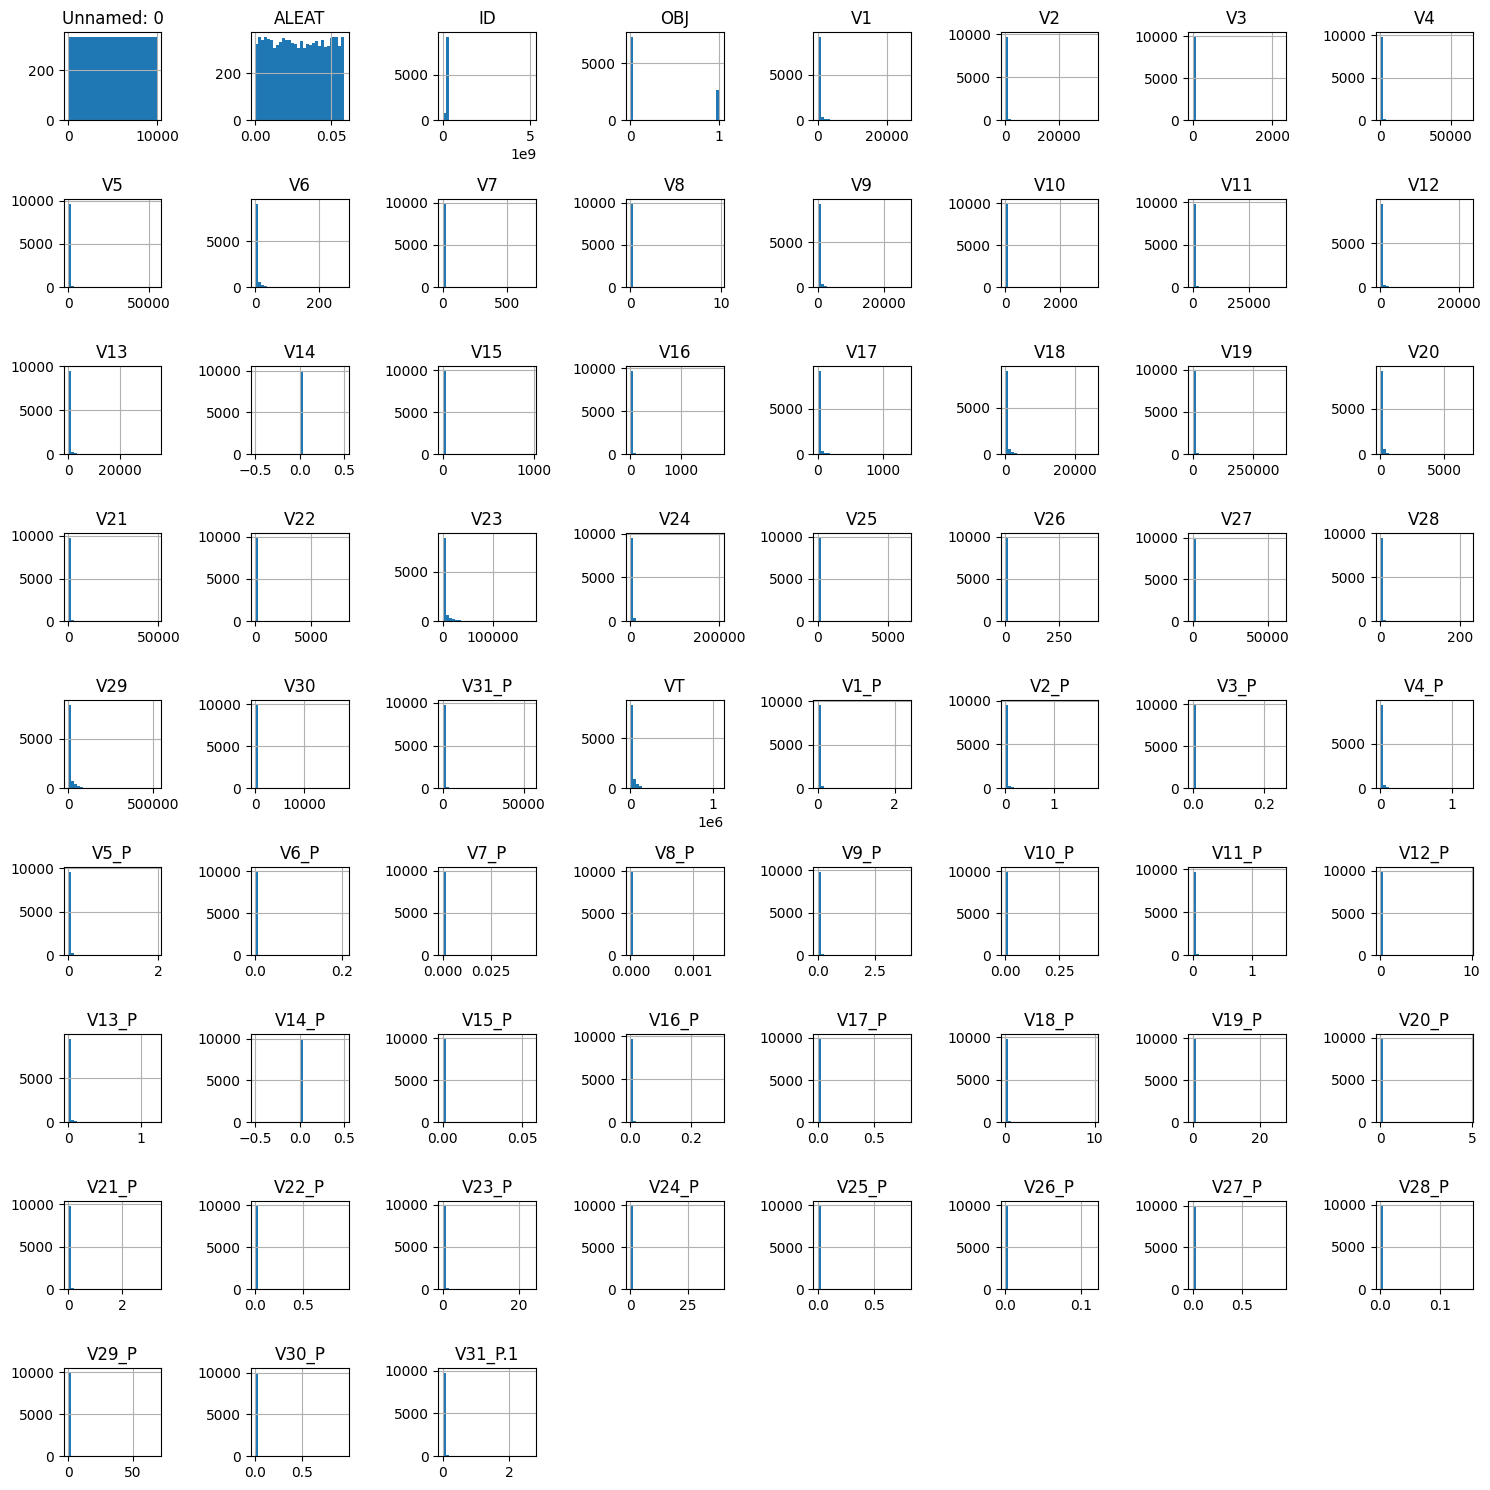

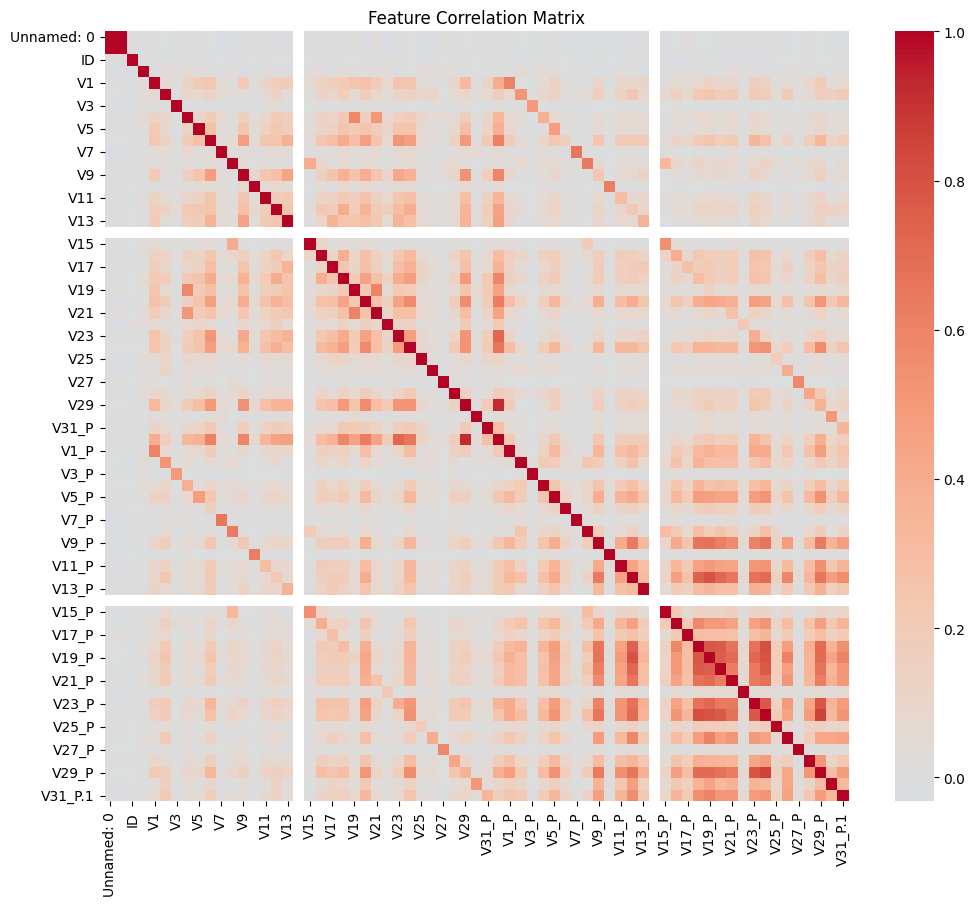


Top features correlated with target:
OBJ      1.000000
V4       0.057686
V2_P     0.052559
V4_P     0.046250
V18      0.041480
V21_P    0.038599
V2       0.037323
V16      0.035592
V28      0.034582
V21      0.033947
V25      0.032404
V22      0.032132
V26      0.025945
V9       0.025846
V5       0.025720
Name: OBJ, dtype: float64


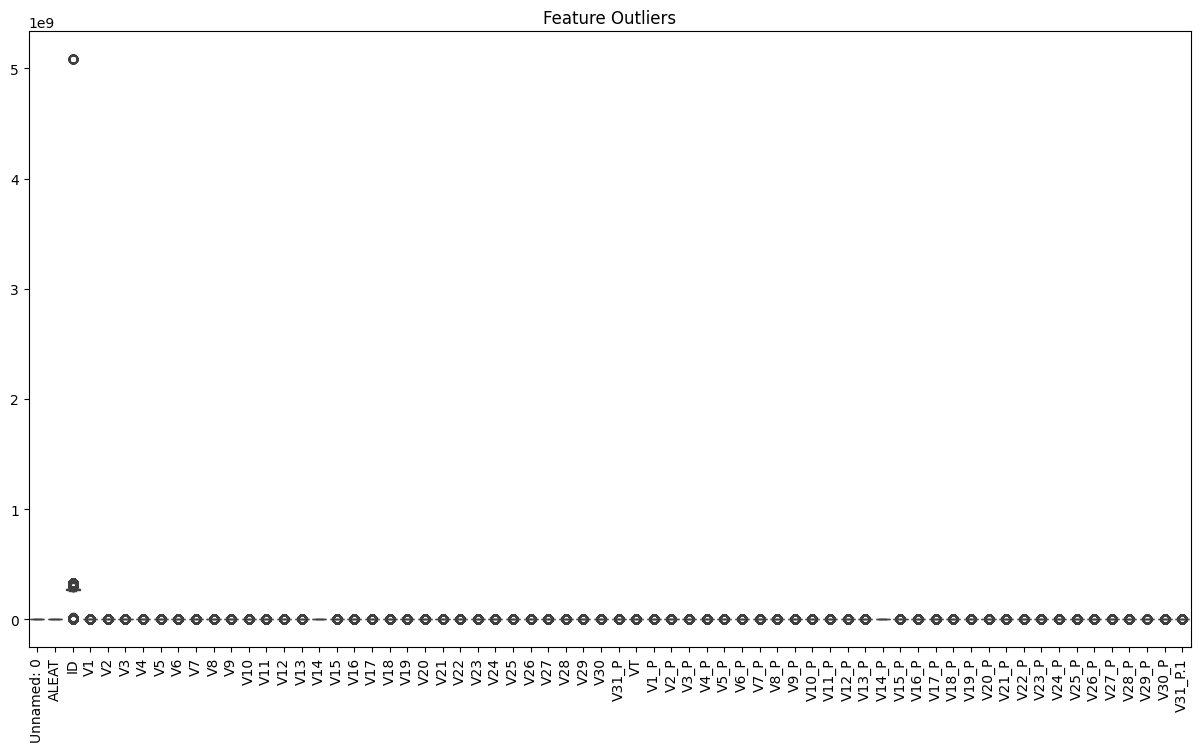

In [128]:
# ======================
#  DATA QUALITY INVESTIGATION
# ======================
print("\n=== DATA QUALITY ANALYSIS ===")

# 1. Class Distribution
class_dist = data['OBJ'].value_counts(normalize=True)
print(f"Class Distribution:\n{class_dist}")

# 2. Feature Distributions
plt.figure(figsize=(15, 10))
data.hist(bins=30, figsize=(15, 15))
plt.tight_layout()
plt.savefig('feature_distributions.png')
plt.show()

# 3. Correlation Analysis
plt.figure(figsize=(12, 10))
corr_matrix = data.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.savefig('correlation_matrix.png')
plt.show()

# 4. Label Leakage Check
target_corr = corr_matrix['OBJ'].abs().sort_values(ascending=False)
print("\nTop features correlated with target:")
print(target_corr.head(15))

# 5. Outlier Detection
plt.figure(figsize=(15, 8))
sns.boxplot(data=data.drop('OBJ', axis=1))
plt.title('Feature Outliers')
plt.xticks(rotation=90)
plt.savefig('outliers.png')
plt.show()

In [129]:
# ======================
#  FEATURE ENGINEERING
# ======================
print("\n=== FEATURE ENGINEERING ===")

# 1. Create interaction features
print("Creating interaction features...")
for i in range(1, 6):
    for j in range(i+1, 7):
        if f'V{i}' in data.columns and f'V{j}' in data.columns:
            data[f'V{i}_V{j}_int'] = data[f'V{i}'] * data[f'V{j}']
            data[f'V{i}_V{j}_diff'] = data[f'V{i}'] - data[f'V{j}']

# 2. Create polynomial features
print("Creating polynomial features...")
poly_features = data[[f'V{i}' for i in range(1, 6) if f'V{i}' in data.columns]]
if not poly_features.empty:
    poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
    poly_transformed = poly.fit_transform(poly_features)
    poly_cols = [f'poly_{i}' for i in range(poly_transformed.shape[1])]
    poly_df = pd.DataFrame(poly_transformed, columns=poly_cols)
    data = pd.concat([data, poly_df], axis=1)

# 3. Domain-specific features
print("Creating domain-specific features...")
if 'abs_sum' in data.columns and 'rel_sum' in data.columns:
    data['abs_rel_ratio'] = data['abs_sum'] / (data['rel_sum'] + 1e-6)
    data['abs_rel_diff'] = data['abs_sum'] - data['rel_sum']

# 4. Aggregate features
print("Creating aggregate features...")
v_cols = [col for col in data.columns if col.startswith('V') and '_' not in col]
if v_cols:
    data['V_mean'] = data[v_cols].mean(axis=1)
    data['V_std'] = data[v_cols].std(axis=1)
    data['V_max'] = data[v_cols].max(axis=1)

print(f"Total features after engineering: {data.shape[1]}")


=== FEATURE ENGINEERING ===
Creating interaction features...
Creating polynomial features...
Creating domain-specific features...
Creating aggregate features...
Total features after engineering: 115


In [130]:
# ======================
#  DATA PREPARATION
# ======================
print("\nPreparing data for modeling...")

# Select features and target
X = data.drop('OBJ', axis=1)
y = data['OBJ']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Training shape: {X_train.shape}, Test shape: {X_test.shape}")


Preparing data for modeling...
Training shape: (8000, 114), Test shape: (2000, 114)


In [131]:
# ======================
#  CLASS IMBALANCE HANDLING
# ======================
print("\nHandling class imbalance...")

# Apply SMOTE
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print(f"Resampled training shape: {X_train_res.shape}")

# Calculate class weights
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"Class ratio (0:1): {class_ratio:.2f}:1")


Handling class imbalance...
Resampled training shape: (8857, 114)
Class ratio (0:1): 2.82:1


In [132]:
# ======================
#  MODEL PIPELINES
# ======================

# Logistic Regression Pipeline
lr_pipe = ImbPipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42, sampling_strategy='minority')),
    ('clf', LogisticRegression(
        random_state=42,
        max_iter=5000,  # Increased iterations
        class_weight='balanced',
        solver='saga',  # Handles L1/L2/elasticnet
        tol=1e-3,       # Relaxed tolerance
        n_jobs=-1
    ))
])

# SVM Pipeline
svm_pipe = ImbPipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler()),  # Better for SVM than StandardScaler
    ('smote', SMOTE(random_state=42, sampling_strategy='minority')),
    ('clf', SVC(
        random_state=42,
        probability=True,
        class_weight='balanced',
        kernel='rbf',    # Default kernel
        gamma='scale',   # Default gamma
        cache_size=1000  # Larger cache for big datasets
    ))
])

# Random Forest Pipeline
rf_pipe = ImbPipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('smote', SMOTE(random_state=42, sampling_strategy='minority')),
    ('clf', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# XGBoost Pipeline
xgb_pipe = ImbPipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('smote', SMOTE(random_state=42, sampling_strategy='minority')),
    ('clf', XGBClassifier(random_state=42, eval_metric='logloss',
                          scale_pos_weight=class_dist[0]/class_dist[1]))
])

# Decision Tree Pipeline
dt_pipe = ImbPipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('smote', SMOTE(random_state=42, sampling_strategy='minority')),
    ('clf', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
])


In [133]:
# ======================
#  HYPERPARAMETER GRIDS
# ======================

# Logistic Regression Parameters
lr_params = [
    {
        'clf__penalty': ['l1'],
        'clf__C': [0.01, 0.1, 1, 10],
        'clf__solver': ['saga'],
        'clf__l1_ratio': [None]  # Not used for L1
    },
    {
        'clf__penalty': ['l2'],
        'clf__C': [0.01, 0.1, 1, 10],
        'clf__solver': ['saga'],
        'clf__l1_ratio': [None]  # Not used for L2
    },
    {
        'clf__penalty': ['elasticnet'],
        'clf__C': [0.01, 0.1, 1, 10],
        'clf__solver': ['saga'],
        'clf__l1_ratio': [0.3, 0.5, 0.7]  # Only for elasticnet
    }
]

# SVM Parameters
svm_params = {
    'clf__C': [0.1, 1, 10],
    'clf__kernel': ['linear', 'rbf'],
    'clf__gamma': ['scale', 'auto']
}

# Random Forest Parameters
rf_params = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [5, 10, None],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2]
}

# XGBoost Parameters
xgb_params = {
    'clf__n_estimators': [100, 200],
    'clf__learning_rate': [0.01, 0.1],
    'clf__max_depth': [3, 5],
    'clf__subsample': [0.8, 1.0]
}

# Decision Tree Parameters
dt_params = {
    'clf__max_depth': [None, 5, 10],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2]
}

In [134]:
# ======================
#  MODEL TRAINING
# ======================
models = {
    'LogisticRegression': (lr_pipe, lr_params),
    'RandomForest': (rf_pipe, rf_params),
    'XGBoost': (xgb_pipe, xgb_params),
    'SVM': (svm_pipe, svm_params),
    'DecisionTree': (dt_pipe, dt_params)
}

best_models = {}
results = []
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

print("\n=== MODEL TRAINING ===")
for name, (pipe, params) in models.items():
    print(f"\n{'='*40}")
    print(f"Training {name}...")
    print(f"{'='*40}")

    try:
        # Grid Search with error handling
        gs = GridSearchCV(
            estimator=pipe,
            param_grid=params,
            scoring='roc_auc',
            cv=cv,
            n_jobs=-1,
            verbose=1,
            error_score='raise'  # Get detailed errors
        )
        gs.fit(X_train, y_train)

        # Store best model
        best_models[name] = gs.best_estimator_

        # Predictions
        y_pred = gs.predict(X_test)
        y_proba = gs.predict_proba(X_test)[:, 1]

        # Metrics
        metrics = {
            'Model': name,
            'Best Params': gs.best_params_,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred, zero_division=0),
            'Recall': recall_score(y_test, y_pred),
            'F1-Score': f1_score(y_test, y_pred),
            'ROC-AUC': roc_auc_score(y_test, y_proba)
        }
        results.append(metrics)

        print(f"\n{name} Best Parameters: {gs.best_params_}")
        print(f"Test ROC-AUC: {metrics['ROC-AUC']:.4f}")
        print(f"Test Recall: {metrics['Recall']:.4f}")

    except Exception as e:
        print(f"\nERROR in {name}: {str(e)}")
        print("Trying fallback configuration...")

        # Fallback to default model without grid search
        try:
            pipe.set_params(**{k.split('__')[1]: v for k, v in params[0].items()} if isinstance(params, list) else {k.split('__')[1]: v for k, v in params.items()})
            pipe.fit(X_train, y_train)

            y_pred = pipe.predict(X_test)
            y_proba = pipe.predict_proba(X_test)[:, 1]

            metrics = {
                'Model': name + '_Fallback',
                'Best Params': 'Default',
                'Accuracy': accuracy_score(y_test, y_pred),
                'Precision': precision_score(y_test, y_pred, zero_division=0),
                'Recall': recall_score(y_test, y_pred),
                'F1-Score': f1_score(y_test, y_pred),
                'ROC-AUC': roc_auc_score(y_test, y_proba)
            }
            results.append(metrics)

            print(f"Fallback {name} Performance:")
            print(f"Test ROC-AUC: {metrics['ROC-AUC']:.4f}")

        except Exception as fallback_e:
            print(f"Fallback failed: {str(fallback_e)}")
            continue


=== MODEL TRAINING ===

Training LogisticRegression...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

LogisticRegression Best Parameters: {'clf__C': 0.01, 'clf__l1_ratio': 0.3, 'clf__penalty': 'elasticnet', 'clf__solver': 'saga'}
Test ROC-AUC: 0.5417
Test Recall: 0.4637

Training RandomForest...
Fitting 3 folds for each of 24 candidates, totalling 72 fits

RandomForest Best Parameters: {'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}
Test ROC-AUC: 0.5925
Test Recall: 0.4198

Training XGBoost...
Fitting 3 folds for each of 16 candidates, totalling 48 fits

XGBoost Best Parameters: {'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_estimators': 100, 'clf__subsample': 1.0}
Test ROC-AUC: 0.6024
Test Recall: 0.7977

Training SVM...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

SVM Best Parameters: {'clf__C': 10, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}
Test ROC-AUC: 0.5376
Test Recall: 0.45


=== MODEL COMPARISON ===
                Model                                        Best Params  \
2             XGBoost  {'clf__learning_rate': 0.1, 'clf__max_depth': ...   
1        RandomForest  {'clf__max_depth': 10, 'clf__min_samples_leaf'...   
4        DecisionTree  {'clf__max_depth': 5, 'clf__min_samples_leaf':...   
0  LogisticRegression  {'clf__C': 0.01, 'clf__l1_ratio': 0.3, 'clf__p...   
3                 SVM  {'clf__C': 10, 'clf__gamma': 'scale', 'clf__ke...   

   Accuracy  Precision    Recall  F1-Score   ROC-AUC  
2    0.4485   0.295406  0.797710  0.431150  0.602404  
1    0.6295   0.334855  0.419847  0.372566  0.592482  
4    0.5445   0.309735  0.601145  0.408825  0.569777  
0    0.5755   0.299630  0.463740  0.364045  0.541729  
3    0.5790   0.299748  0.454198  0.361153  0.537639  

Best Model: XGBoost (ROC-AUC: 0.6024)

Optimal threshold: 0.4870 (default=0.5)

Optimized Performance:
Accuracy: 0.4385
Precision: 0.2947
Recall: 0.8206
F1-Score: 0.4337


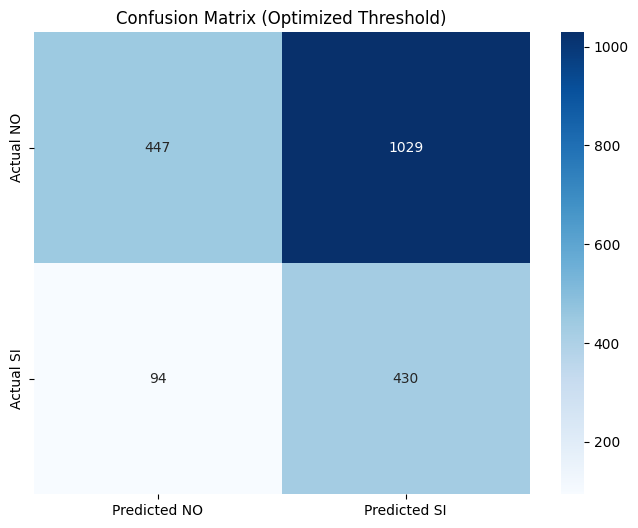


Saved best model as 'best_model.pkl'


In [135]:
# ======================
#  RESULTS ANALYSIS
# ======================
if results:
    results_df = pd.DataFrame(results)
    print("\n=== MODEL COMPARISON ===")
    print(results_df.sort_values('ROC-AUC', ascending=False))

    # Select best model
    best_model_name = results_df.loc[results_df['ROC-AUC'].idxmax(), 'Model']
    best_model = best_models[best_model_name]
    print(f"\nBest Model: {best_model_name} (ROC-AUC: {results_df['ROC-AUC'].max():.4f})")

    # Threshold optimization
    y_proba = best_model.predict_proba(X_test)[:, 1]
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)
    best_threshold = thresholds[np.argmax(f1_scores)]

    print(f"\nOptimal threshold: {best_threshold:.4f} (default=0.5)")
    y_pred_opt = (y_proba >= best_threshold).astype(int)

    print("\nOptimized Performance:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_opt):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred_opt, zero_division=0):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred_opt):.4f}")
    print(f"F1-Score: {f1_score(y_test, y_pred_opt):.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_opt)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted NO', 'Predicted SI'],
                yticklabels=['Actual NO', 'Actual SI'])
    plt.title('Confusion Matrix (Optimized Threshold)')
    plt.savefig('confusion_matrix.png')
    plt.show()

    # Save best model
    joblib.dump(best_model, 'best_model.pkl')
    print("\nSaved best model as 'best_model.pkl'")
else:
    print("\nNo models trained successfully")

In [136]:
# ======================
#  ENSEMBLE STACKING
# ======================
if best_models:
    print("\n=== BUILDING STACKING ENSEMBLE ===")

    # Create list of best models
    estimators = [(name, model) for name, model in best_models.items()]

    # Create stacking classifier
    stacking = StackingClassifier(
        estimators=estimators,
        final_estimator=LogisticRegression(max_iter=5000, class_weight='balanced'),
        cv=cv,
        n_jobs=-1
    )

    # Train stacking model
    stacking.fit(X_train_res, y_train_res)

    # Evaluate
    y_pred_stack = stacking.predict(X_test)
    y_proba_stack = stacking.predict_proba(X_test)[:, 1]

    stack_metrics = {
        'Model': 'Stacking_Ensemble',
        'Accuracy': accuracy_score(y_test, y_pred_stack),
        'Precision': precision_score(y_test, y_pred_stack, zero_division=0),
        'Recall': recall_score(y_test, y_pred_stack),
        'F1-Score': f1_score(y_test, y_pred_stack),
        'ROC-AUC': roc_auc_score(y_test, y_proba_stack)
    }

    print("\nStacking Ensemble Performance:")
    for metric, value in stack_metrics.items():
        if metric != 'Model':
            print(f"{metric}: {value:.4f}")

    # Compare with best single model
    if results:
        print("\nComparison with Best Single Model:")
        best_roc = results_df['ROC-AUC'].max()
        print(f"Best Single Model ROC-AUC: {best_roc:.4f}")
        print(f"Ensemble ROC-AUC: {stack_metrics['ROC-AUC']:.4f}")
        improvement = (stack_metrics['ROC-AUC'] - best_roc) / best_roc * 100
        print(f"Improvement: {improvement:.2f}%")

    # Save stacking model
    joblib.dump(stacking, 'stacking_model.pkl')
    print("\nSaved stacking ensemble as 'stacking_model.pkl'")
else:
    print("\nNo models available for stacking")


=== BUILDING STACKING ENSEMBLE ===

Stacking Ensemble Performance:
Accuracy: 0.6060
Precision: 0.3286
Recall: 0.4828
F1-Score: 0.3910
ROC-AUC: 0.5947

Comparison with Best Single Model:
Best Single Model ROC-AUC: 0.6024
Ensemble ROC-AUC: 0.5947
Improvement: -1.27%

Saved stacking ensemble as 'stacking_model.pkl'
